## 1. Import Libraries

In [1]:
import math
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime as dt
from binance import Client
import csv
import mplfinance as mpf
import seaborn as sns

## 2. Functions for Data Extraction

In [2]:
# Obtiene los datos históricos de la moneda deseada
def getdata(symbol, period, start, end):
    """
    Devuelve los datos históricos de velas para una moneda.
    :param symbol: Nombre de la moneda.
    :param period: Intervalo de tiempo de las velas.
    :param start: Fecha de inicio.
    :param end: Fecha de fin.
    :return: Datos de velas.
    """
    return client.get_historical_klines(symbol, period, start, end)

# Genera un archivo CSV con los datos históricos de una moneda
def make_csv(symbol, candles):
    """
    Crea un archivo CSV con los datos históricos de una moneda.
    :param symbol: Nombre de la moneda.
    :param candles: Datos históricos.
    """
    with open(symbol + ".csv", "a", newline="") as csvfile:
        cursor = csv.writer(csvfile)
        cursor.writerows(candles)

# Genera archivos CSV con los datos históricos de múltiples monedas
def multiple_csv(symbols, interval, start, end):
    """
    Crea archivos CSV para una lista de monedas.
    :param symbols: Lista de monedas.
    :param interval: Intervalo de tiempo de las velas.
    :param start: Fecha de inicio.
    :param end: Fecha de fin.
    """
    for symbol in symbols:
        make_csv(symbol, getdata(symbol, interval, str(start), str(end)))
        print(symbol, "CSV listo.")

# Convierte un timestamp a una fecha
def calculate_time(timestamp):
    """
    Convierte un timestamp a formato de fecha.
    :param timestamp: Timestamp dado.
    :return: Fecha correspondiente.
    """
    return dt.fromtimestamp(timestamp / 1000)


## 3. Fetch Bitcoin Data

In [3]:
# Crea un objeto cliente de la librería Binance
client = Client(None, None)

In [4]:
# Verifica si el archivo existe y lo elimina
import os
archivo_excel = "BTCUSDT.csv"
if os.path.exists(archivo_excel):
    os.remove(archivo_excel)

# Obtiene datos históricos de Bitcoin y genera el archivo CSV
multiple_csv(["BTCUSDT"], client.KLINE_INTERVAL_1HOUR, "1 January 2010", "31 January 2025")

BTCUSDT CSV listo.


## 4. Data Analysis

In [5]:
# Lee los datos históricos de Bitcoin como un DataFrame con nombres de columnas
headers = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]
data = pd.read_csv("BTCUSDT.csv", names=headers)
data.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,QAV,NAT,TBBAV,TBQAV,Ignore
0,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,150952.477943,0
1,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,92608.279728,0
2,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,20795.317224,0
3,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443249,1502956799999,19241.058300,25,2.602292,11291.347015,0
4,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.503586,28,0.814655,3552.746817,0


In [6]:
# Convierte el tiempo de apertura y cierre de timestamp a formato de fecha
data["Open Time"] = data["Open Time"].apply(calculate_time)
data["Close Time"] = data["Close Time"].apply(calculate_time)

In [7]:
# Ver información general
df = data.copy()
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65245 entries, 0 to 65244
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Open Time   65245 non-null  datetime64[ns]
 1   Open        65245 non-null  float64       
 2   High        65245 non-null  float64       
 3   Low         65245 non-null  float64       
 4   Close       65245 non-null  float64       
 5   Volume      65245 non-null  float64       
 6   Close Time  65245 non-null  datetime64[ns]
 7   QAV         65245 non-null  float64       
 8   NAT         65245 non-null  int64         
 9   TBBAV       65245 non-null  float64       
 10  TBQAV       65245 non-null  float64       
 11  Ignore      65245 non-null  int64         
dtypes: datetime64[ns](2), float64(8), int64(2)
memory usage: 6.0 MB
None
                           Open Time           Open           High  \
count                          65245   65245.000000   65245.000000   
mean 

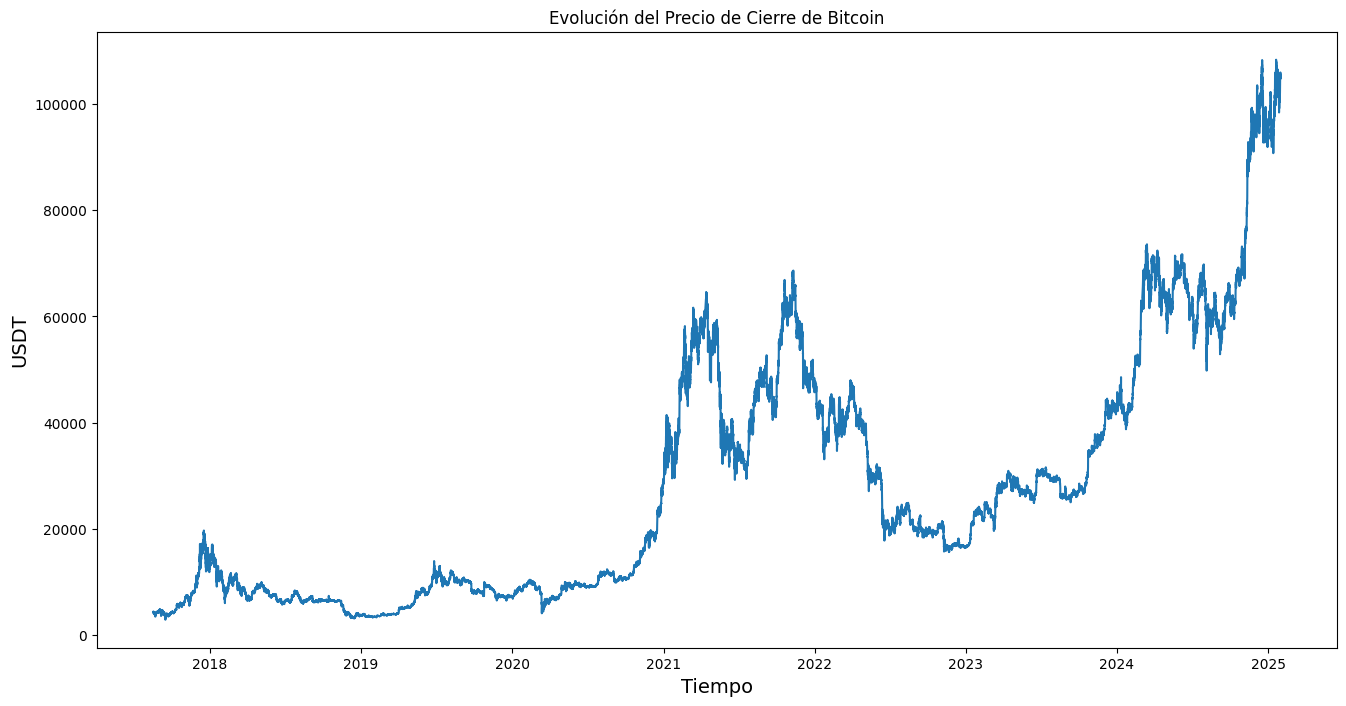

In [8]:
# Visualiza el historial de precios de cierre
plt.figure(figsize=(16, 8))
plt.title("Evolución del Precio de Cierre de Bitcoin")
plt.plot(df["Close Time"], df["Close"])
plt.xlabel("Tiempo", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.show()

Esta gráfica muestra la evolución del precio del activo a lo largo del tiempo. Se pueden identificar tendencias alcistas y bajistas, así como períodos de consolidación en los que el precio se mantiene estable dentro de un rango.
Algo a destacar son los períodos de estabilidad, ya que estos pueden generar dificultades en la predicción, ya que el modelo podría predecir valores muy similares sin captar cambios significativos. Por otro lado, cuando cuando el precio presenta tendencias claras, el modelo LSTM podrá aprender mejor los patrones.

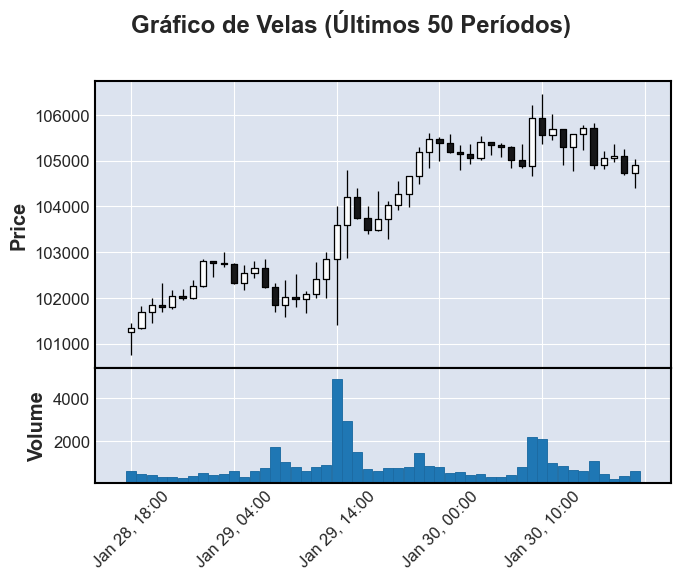

In [9]:
df_candlestick = df[["Open Time", "Open", "High", "Low", "Close", "Volume"]].set_index("Open Time")
mpf.plot(df_candlestick.tail(50), type="candle", volume=True, title="Gráfico de Velas (Últimos 50 Períodos)")

El gráfico de velas nos puede ayudar para analizar la acción del precio en períodos cortos. Con este gráfico es posible detectar patrones que pueden indicar reversiones de tendencia. Si predominan velas con cuerpos largos, se evidencia una tendencia clara, mientras que sombras largas pueden indicar indecisión en el mercado. Estos patrones pueden ser utilizados para complementar el modelo LSTM incorporando datos sobre máximos y mínimos, y no solo el precio de cierre, lo que ayudaría a capturar mejor la dinámica del mercado.

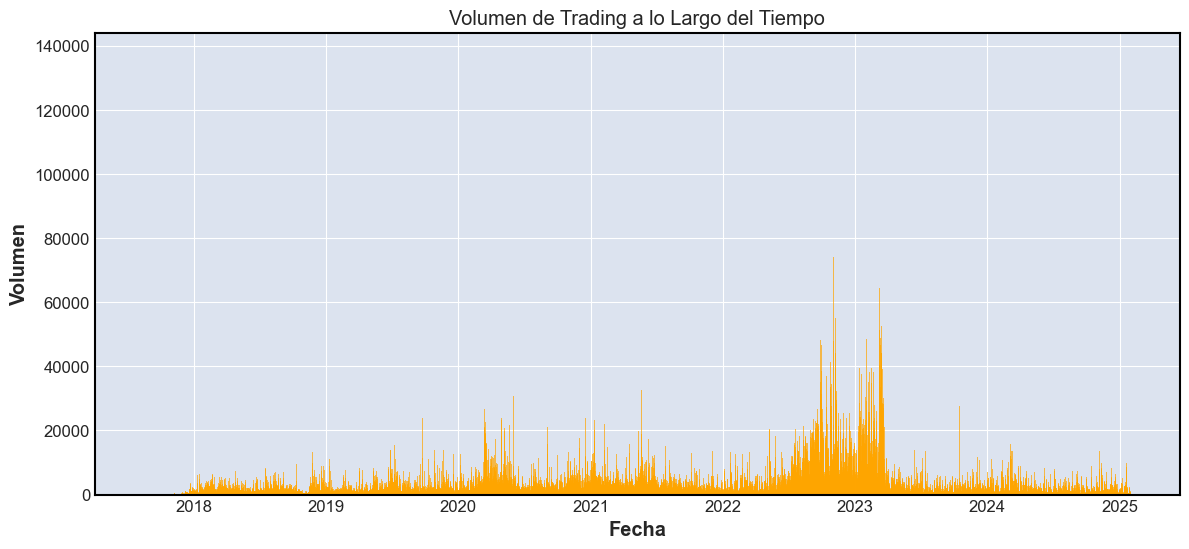

In [10]:
plt.figure(figsize=(14, 6))
plt.bar(df["Open Time"], df["Volume"], color='orange', alpha=0.7)
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.title("Volumen de Trading a lo Largo del Tiempo")
plt.show()

El gráfico de volumen nos permite ver la cantidad de activos intercambiados en cada período. Se puede notar que los incrementos en volumen suelen coincidir con movimientos bruscos en el precio, lo que indica un mayor interés del mercado en determinados momentos. Un volumen alto antes de un movimiento fuerte puede señalar fases de acumulación o distribución. Por otro lado, un volumen bajo sugiere menor interés y puede estar relacionado con una menor volatilidad en el precio. Esto nos proporciona información clave sobre la actividad del mercado.

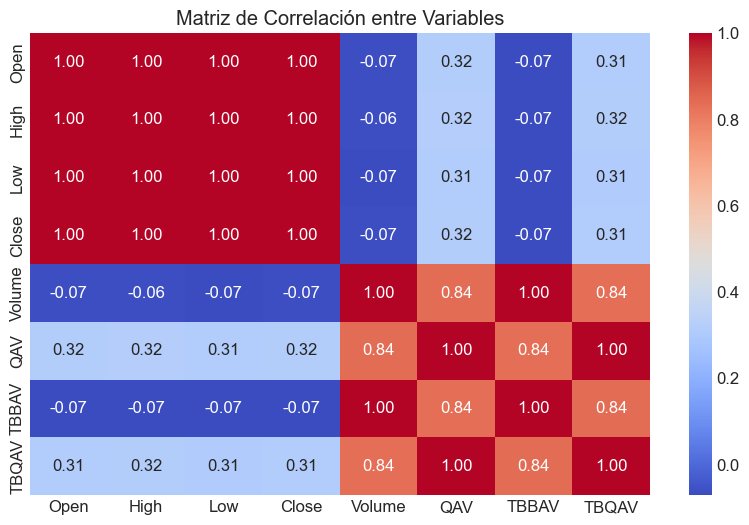

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[["Open", "High", "Low", "Close", "Volume", "QAV", "TBBAV", "TBQAV"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Variables")
plt.show()

Este análisis de correlación entre variables nos ayuda a identificar relaciones entre los distintos valores de precios y el volumen de trading. Como era de esperarse, los precios de apertura, máximo, mínimo y cierre están altamente correlacionados entre sí. Sin embargo, el volumen presenta una correlación más variable con los precios, lo que sugiere que en ciertos momentos puede ser un indicador importante de cambios de tendencia. Reducir la cantidad de variables redundantes en el modelo LSTM puede ayudar a mejorar su eficiencia sin perder información clave.

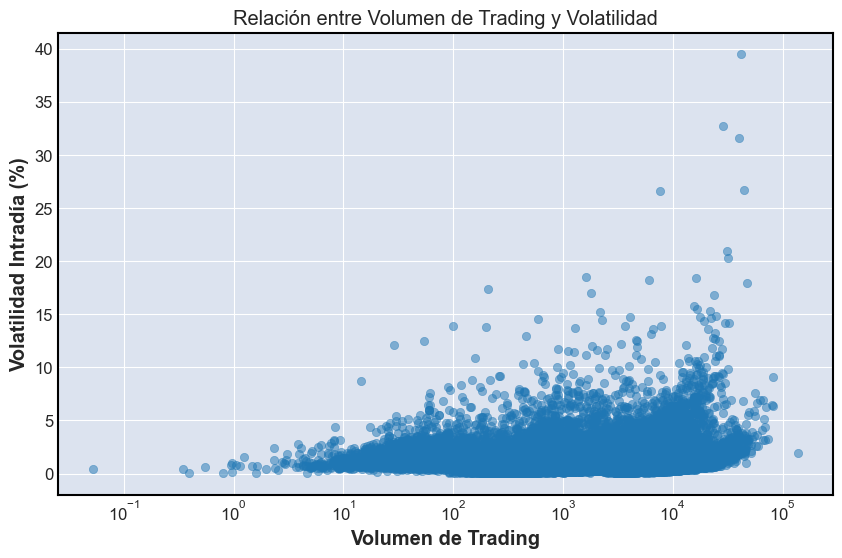

In [12]:
df['Volatility (%)'] = ((df['High'] - df['Low']) / df['Low']) * 100

# Crear el gráfico de dispersión entre volumen y volatilidad
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['Volume'], y=df['Volatility (%)'], alpha=0.5, edgecolor=None)

plt.xscale("log")  # Escala logarítmica para manejar diferencias grandes en volumen
plt.xlabel("Volumen de Trading")
plt.ylabel("Volatilidad Intradía (%)")
plt.title("Relación entre Volumen de Trading y Volatilidad")
plt.grid(True)
plt.show()

Cada punto en el gráfico representa un período de tiempo (por ejemplo, 1 hora o 1 día, dependiendo de los datos).
- El eje X representa el volumen de trading, es decir, cuántas unidades del activo se negociaron en ese período.
- El eje Y representa la volatilidad intradía (%), que mide cuánto cambió el precio dentro de ese período.

Notamos que a mayor volumen hay mayor volatilidad, significa que el mercado tiende a moverse con más fuerza cuando hay más actividad de trading. Esto podría indicar que en momentos de alto volumen, el modelo LSTM debería prestar especial atención, ya que estos períodos pueden ser más impredecibles.

Por otro lado, la volatilidad no cambia mucho con el volumen, significa que las fluctuaciones de precio no dependen tanto de la cantidad de operaciones en el mercado, sino de otros factores externos.

## 4. Create Train and Test Data

In [13]:
# Crea un nuevo DataFrame con solo la columna "Close"
close = data.filter(["Close"])

# Convierte el DataFrame en un array de NumPy
close_array = close.values

# Obtiene la cantidad de datos para entrenamiento (80% del total)
train_close_len = math.ceil(len(close_array) * 0.8)

In [14]:
# Normaliza los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_array)

In [15]:
# Crea el conjunto de datos de entrenamiento
train_data = scaled_data[0 : train_close_len, :]

# Crea X_train y y_train
X_train = []
y_train = []
wz = 24 * 7  # Tamaño de la ventana (una semana de datos horarios)

for i in range(wz, len(train_data)):
    X_train.append(train_data[i - wz : i, 0])  # Secuencia de entrada
    y_train.append(train_data[i, 0])  # Valor objetivo

# Convierte X_train y y_train en arrays de NumPy
X_train, y_train = np.array(X_train), np.array(y_train)

# Redimensiona los datos (descomentarlo si es necesario)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [16]:
# Crea el conjunto de datos de prueba
test_data = scaled_data[train_close_len - wz : , :]

# Crea X_test
X_test = []
for i in range(wz, len(test_data)):
    X_test.append(test_data[i - wz : i, 0])

# Convierte X_test en un array de NumPy y redimensiona si es necesario
X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define y_test con los valores reales de cierre escalados
y_test = scaled_data[train_close_len:, 0]

In [17]:
# Imprime las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Dimensiones:
X_train: (52028, 168) y_train: (52028,)
X_test: (13049, 168) y_test: (13049,)


In [18]:
# Guarda los datos en archivos
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("scaler.npy", scaler)

In [19]:
# Carga los datos desde los archivos guardados
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
scaler = np.load("scaler.npy", allow_pickle=True)